# Static power flow

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from dem import *

matplotlib.rc("figure", figsize=(7,7))
matplotlib.rc("lines", linewidth=2)

## Basic examples

### Hello world

In [13]:
load = FixedLoad(power=100)
gen = Generator(power_max=1000, alpha=0.01, beta=100)
net = Net([load.terminals[0], gen.terminals[0]])
network = Group([load, gen], [net])

network.init_problem()
network.problem.solve()
print network.results.summary()

Terminal                  Power
--------                  -----
FixedLoad[0]           100.0000
Generator[0]          -100.0000

Net                       Price
---                       -----
Net                    102.0001



### Curtailable load

In [17]:
load = CurtailableLoad(power=1000, alpha=150)
gen = Generator(power_max=1000, alpha=1, beta=100)
net = Net([load.terminals[0], gen.terminals[0]])
network = Group([load, gen], [net])

network.init_problem()
network.problem.solve()
print network.results.summary()

Terminal                  Power
--------                  -----
CurtailableLoad[0]      25.0026
Generator[0]           -25.0026

Net                       Price
---                       -----
Net                    150.0000



### Two generators, transmission line

In [22]:
load = FixedLoad(power=100)
gen1 = Generator(power_max=1000, alpha=0.01, beta=100, name="Gen1")
gen2 = Generator(power_max=100, alpha=0.1, beta=0.1, name="Gen2")
line = TransmissionLine(power_max=50)

net1 = Net([load.terminals[0], gen1.terminals[0], line.terminals[0]])
net2 = Net([gen2.terminals[0], line.terminals[1]])
network = Group([load, gen1, gen2, line], [net1, net2])

network.init_problem()
network.problem.solve()
print network.results.summary()

Terminal                  Power
--------                  -----
FixedLoad[0]           100.0000
TransmissionLine[0]    -50.0000
TransmissionLine[1]     50.0000
Gen2[0]                -50.0000
Gen1[0]                -50.0000

Net                       Price
---                       -----
Net                    101.0000
Net                     10.1000



### Three buses

Figure 2.1 from Kraning, et al. without the battery.

![Three bus example](./three_bus.png)



In [24]:
load1 = FixedLoad(power=50, name="Load1")
load2 = FixedLoad(power=100, name="Load2")
gen1 = Generator(power_max=1000, alpha=0.01, beta=100, name="Gen1")
gen2 = Generator(power_max=100, alpha=0.1, beta=0.1, name="Gen2")
line1 = TransmissionLine(power_max=50)
line2 = TransmissionLine(power_max=10)
line3 = TransmissionLine(power_max=50)

net1 = Net([load1.terminals[0], gen1.terminals[0], line1.terminals[0], line2.terminals[0]])
net2 = Net([load2.terminals[0], line1.terminals[1], line3.terminals[0]])
net3 = Net([gen2.terminals[0], line2.terminals[1], line3.terminals[1]])
network = Group([load1, load2, gen1, gen2, line1, line2, line3], [net1, net2, net3])

network.init_problem()
network.problem.solve()
print network.results.summary()

Terminal                  Power
--------                  -----
TransmissionLine[1]     50.0000
TransmissionLine[0]    -10.0000
Gen2[0]                -60.0000
Gen1[0]                -90.0000
TransmissionLine[0]     50.0000
TransmissionLine[1]    -50.0000
Load2[0]               100.0000
Load1[0]                50.0000
TransmissionLine[1]     10.0000
TransmissionLine[0]    -50.0000

Net                       Price
---                       -----
Net                    101.8008
Net                    196.1907
Net                     12.0975



## Grouping devices

We can wrap up several devices and nets into a single device

In [25]:
solar = Generator(power_max=10, alpha=0, beta=0, name="Solar")
load = FixedLoad(power=13)
line = TransmissionLine(power_max=25)
net = Net([load.terminals[0], solar.terminals[0], line.terminals[0]])
home = Group([solar, load, line], [net], [line.terminals[1]], name="Home")

grid = Generator(power_max=1e6, alpha=0.05, beta=100, name="Grid")
meter = Net([line.terminals[1], grid.terminals[0]], name="Meter")
network = Group([home, grid], [meter])

network.init_problem()
network.problem.solve()
print network.results.summary()

Terminal                  Power
--------                  -----
FixedLoad[0]            13.0000
TransmissionLine[1]      3.0000
Solar[0]               -10.0000
Grid[0]                 -3.0000
TransmissionLine[0]     -3.0000

Net                       Price
---                       -----
Net                    100.3000
Meter                  100.3000



## Varying parameters

We can modify a single parameter and reoptimize, which is useful for sweeping over a parameter range.

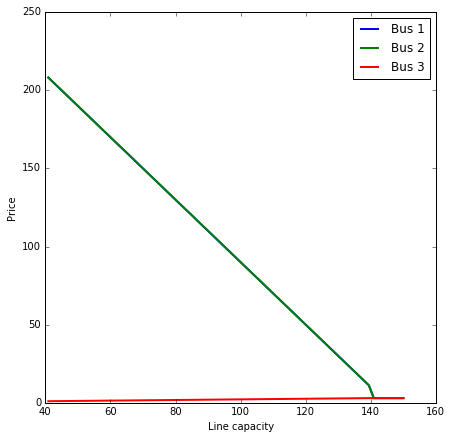

In [28]:
load1 = FixedLoad(power=50, name="Load1")
load2 = FixedLoad(power=100, name="Load2")
gen1 = Generator(power_max=100, alpha=1, beta=10, name="Gen1")
gen2 = Generator(power_max=1000, alpha=0.01, beta=0, name="Gen2")
line1 = TransmissionLine(power_max=100)
line2 = TransmissionLine(power_max=10)
line3 = TransmissionLine(power_max=Parameter(1))

net1 = Net([load1.terminals[0], gen1.terminals[0], line1.terminals[0], line2.terminals[0]])
net2 = Net([load2.terminals[0], line1.terminals[1], line3.terminals[0]])
net3 = Net([gen2.terminals[0], line2.terminals[1], line3.terminals[1]])
network = Group([load1, load2, gen1, gen2, line1, line2, line3], [net1, net2, net3])

network.init_problem()
xs = np.linspace(0, 150, 100)
prices = np.empty((len(xs), 3))
for i, x in enumerate(xs):
    line3.power_max.value = x
    network.problem.solve()
    prices[i,:] = [net.price for net in network.nets]
    
plt.plot(xs, prices)
plt.xlabel("Line capacity")
plt.ylabel("Price")
plt.legend(["Bus 1", "Bus 2", "Bus 3"])